In [ ]:
import lightning as L
from model import CVAE, VoteDataProcessor
import numpy as np

ckpt_path = '/Users/mason/Dropbox (MIT)/Research/cvr-ml/lightning_logs/version_0/checkpoints/epoch=0-step=3209.ckpt'

# Load model
checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'), weights_only=False)
processor = VoteDataProcessor.from_state_dict(checkpoint['data_processor'])
model = CVAE.load_from_checkpoint(
    ckpt_path, 
    map_location='cpu',
    dataloader=None, 
    nitems=processor.nitems,
    n_classes_per_item=processor.get_n_classes_per_item(), 
    latent_dims=2, 
    hidden_layer_size=64, 
    qm=None, 
    learning_rate=1e-3, 
    batch_size=512
)

558

In [12]:
# Get embeddings for a specific race
race_idx = checkpoint["data_processor"]["race_to_idx"]['US PRESIDENT_FEDERAL']  # President
race_name = processor.idx_to_race[race_idx]
candidates = processor.get_all_candidates_for_race(race_idx)

# Extract embeddings (raw + projected)
raw_embeddings = model.encoder.embeddings[race_idx].weight.data.cpu().numpy()
proj_layer = model.encoder.item_proj[race_idx]

with torch.no_grad():
    projected_embeddings = torch.nn.functional.elu(
        proj_layer(torch.from_numpy(raw_embeddings))
    ).numpy()

# Analyze
print(f"Race: {race_name}")
for class_idx, cand_name in candidates.items():
    emb = projected_embeddings[class_idx]
    print(f"  {cand_name}: {emb[:3]}... (norm: {np.linalg.norm(emb):.3f})")

# Compute pairwise distances
from scipy.spatial.distance import pdist, squareform
distances = squareform(pdist(projected_embeddings, metric='cosine'))

# Find most similar pair
min_dist = np.inf
for i in range(len(candidates)):
    for j in range(i+1, len(candidates)):
        if distances[i, j] < min_dist:
            min_dist = distances[i, j]
            most_similar = (candidates[i], candidates[j])

print(f"\nMost similar candidates: {most_similar[0]} & {most_similar[1]} "
      f"(distance: {min_dist:.3f})")

Race: US PRESIDENT_FEDERAL
  ALYSON KENNEDY: [ 0.44277534 -0.6766072  -0.6133738 ]... (norm: 3.566)
  ALYSON KENNEDY MALCOLM JARRETT: [-0.4864846   0.7484592   0.60496294]... (norm: 3.615)
  BILL HAMMONS: [-0.751632    0.8639259  -0.27454725]... (norm: 3.083)
  BILL HAMMONS ERIC BODENSTAB: [-0.6518936   1.600059    0.84570044]... (norm: 3.013)
  BLAKE HUBER: [ 0.02984418  0.509958   -0.46260092]... (norm: 3.159)
  BLAKE HUBER FRANK ATWOOD: [-0.08188483  0.60602635  0.43887165]... (norm: 1.743)
  BRIAN CARROLL: [-0.1985187   0.6813667   0.02536031]... (norm: 3.082)
  BRIAN T CARROLL: [-0.32445562  0.38029447 -0.12812218]... (norm: 1.525)
  BROCK PIERCE: [ 0.39465412  0.4245119  -0.50635666]... (norm: 2.492)
  DARIO HUNTER: [-0.5770205  1.0397074 -0.7260597]... (norm: 2.847)
  DARIO HUNTER DAWN NEPTUNE ADAMS: [-0.21462815  0.27006525 -0.8362736 ]... (norm: 2.698)
  DON BLANKENSHIP: [-0.30075422  1.7707572   0.95724946]... (norm: 3.650)
  DONALD J TRUMP: [ 0.79632074 -0.61439806 -0.126050

In [14]:
from analyze_embeddings import *

analyze_decoder_weights(model, processor, "embedding_analysis")

Saved decoder weights to: embedding_analysis/decoder_weights.csv


,race_name,candidate_name,latent_dim_0,latent_dim_1
0,BOARD OF EDUCATION_STATEWIDE 3,JOYCE RANKIN,-1.799424,-1.007941
1,BOARD OF EDUCATION_STATEWIDE 3,MAYLING SIMPSON,0.270664,0.645963
2,CITY COUNCIL_CASTLE ROCK 1,GENEVA BRIER,0.098030,0.229674
3,CITY COUNCIL_CASTLE ROCK 1,ROBERT WADE,-0.579817,0.031708
4,CITY COUNCIL_CASTLE ROCK 1,RYAN HOLLINGSHEAD,-0.382472,0.684756
...,...,...,...,...
1642,US SENATE_STATEWIDE,CORY GARDNER,-1.272686,-1.323456
1643,US SENATE_STATEWIDE,DANIEL DOYLE,-0.136858,0.008473
1644,US SENATE_STATEWIDE,JOHN W HICKENLOOPER,0.813168,1.198255
1645,US SENATE_STATEWIDE,RAYMON ANTHONY DOANE,0.123660,-0.447405


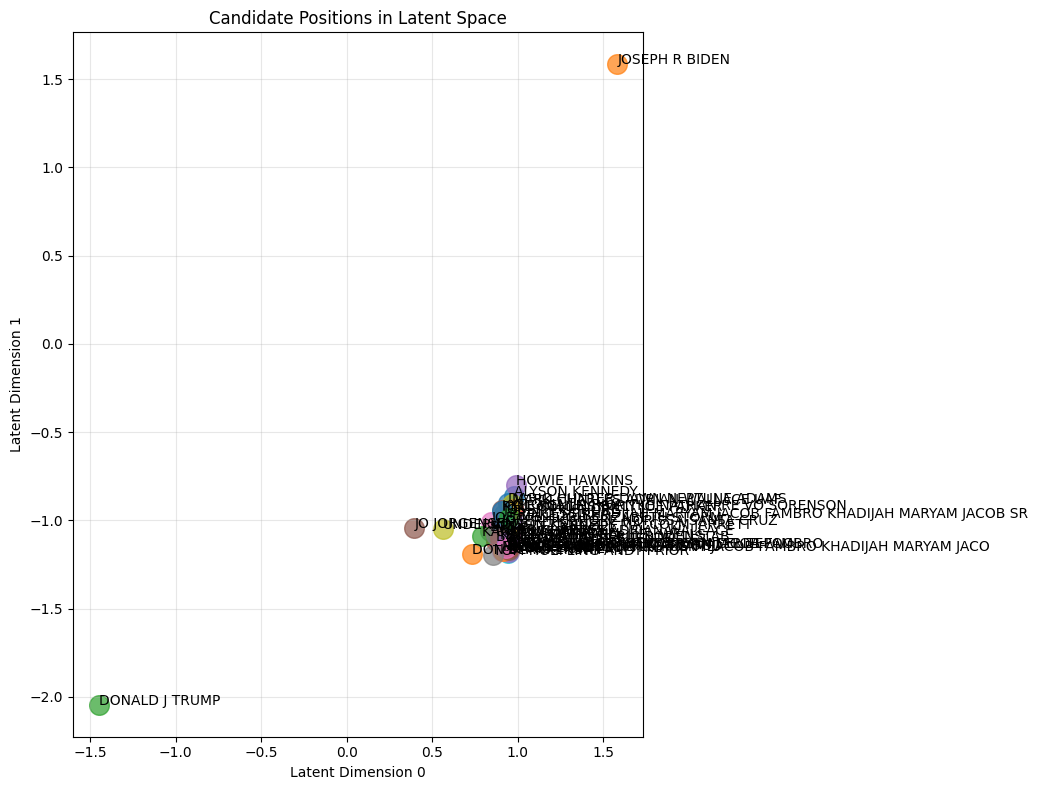

In [18]:
# Get voter latents from your exports
voter_latents = pd.read_csv('outputs/batch_size512_latent_dims2_hidden_size64_emb_dim16_lr0.001_epochs20_n_samples1_voter_latents.csv')

# Get decoder weights
decoder_weights = pd.read_csv('embedding_analysis/decoder_weights.csv')

# For US President race
pres_weights = decoder_weights[decoder_weights['race_name'] == 'US PRESIDENT_FEDERAL']

# Plot: latent dim 0 vs dim 1, colored by candidate preference
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
for _, row in pres_weights.iterrows():
    ax.scatter(row['latent_dim_0'], row['latent_dim_1'], s=200, alpha=0.7,
               label=row['candidate_name'])
    ax.annotate(row['candidate_name'], 
                (row['latent_dim_0'], row['latent_dim_1']),
                fontsize=10)

ax.set_xlabel('Latent Dimension 0')
ax.set_ylabel('Latent Dimension 1')
ax.set_title('Candidate Positions in Latent Space')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('latent_space_interpretation.png', dpi=150)